In [1]:
################################################################################################################
# Run the first 3 cells before running the experiments.
################################################################################################################

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from regression.SlowLogisticRegression import SlowLogisticRegression
from sklearn.linear_model import LogisticRegression
from optimized_sampling.BasicLeverageScoresSampler import BasicLeverageScoresSampler
from utilities.Stopwatch import Stopwatch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
################################################################################################################
# Plotting functions.
################################################################################################################

SERIES_BLUE = '#0066cc'
SERIES_ORANGE = '#ff3300'

def plot_individualized(accuracies, training_times, type, time_scale, autoscale = False):
    fig1, ax1 = plt.subplots(figsize=(5, 5))

    x = np.arange(1, len(accuracies) + 1)
    width = 0.35

    bars1 = ax1.bar(x - width/2, accuracies, width, label='Accuracy', color=SERIES_ORANGE, zorder=1)
    ax1.set_ylabel('Accuracy (%)', color=SERIES_ORANGE)
    ax1.tick_params(axis='y', labelcolor=SERIES_ORANGE)
    ax1.grid(axis='y', color='lightgray', linestyle='-', linewidth=0.5, zorder=0)
    ax1.set_axisbelow(True)

    ax1_twin = ax1.twinx()
    bars2 = ax1_twin.bar(x + width/2, training_times, width, label='Training Time', color=SERIES_BLUE, zorder=1)
    ax1_twin.set_ylabel(f"Training Time ({time_scale})", color=SERIES_BLUE)
    ax1_twin.tick_params(axis='y', labelcolor=SERIES_BLUE)

    if not autoscale:
        ax1_twin.set_ybound(0, 2.2)

    ax1.set_xlabel('Run')
    ax1.set_title(f"{type}\nAccuracy and Training Time for {len(accuracies)} Runs\n\n")
    ax1.set_xticks(x)

    if not autoscale:
        ax1.set_ybound(0, 1.1)

    ax1.legend(bbox_to_anchor=(0, 1), loc='lower left')
    ax1_twin.legend(bbox_to_anchor=(1, 1), loc='lower right')
    ax1_twin.set_axisbelow(True)

    plt.tight_layout()
    
    plt.show()


def plot_mean(accuracies, training_times, type, time_scale, autoscale = False):
    fig2, ax2 = plt.subplots(figsize=(5, 5))

    mean1, std1 = np.mean(accuracies), np.std(accuracies)
    mean2, std2 = np.mean(training_times), np.std(training_times)
    median1, median2 = np.median(accuracies), np.median(training_times)
    q1_1, q3_1 = np.percentile(accuracies, [25, 75])
    q1_2, q3_2 = np.percentile(training_times, [25, 75])

    ax2.bar(-0.2, mean1, width=0.4, color=SERIES_ORANGE, label='Accuracy')
    ax2.errorbar(-0.2, mean1, yerr=[[max(0, mean1-q1_1)], [max(0, q3_1-mean1)]], capsize=10, color='black')
    ax2.plot(-0.2, median1, marker='s', color='black', markersize=8)
    ax2.grid(axis='y', color='lightgray', linestyle='-', linewidth=0.5, zorder=0)
    ax2.set_axisbelow(True)

    if not autoscale:
        ax2.set_ybound(0, 1.1)

    ax2_twin = ax2.twinx()
    ax2_twin.bar(0.2, mean2, width=0.4, color=SERIES_BLUE, label='Training Time')
    ax2_twin.errorbar(0.2, mean2, yerr=[[max(0, mean2-q1_2)], [max(0, q3_2-mean2)]], capsize=10, color='black')
    ax2_twin.plot(0.2, median2, marker='s', color='black', markersize=8)
    ax2_twin.set_axisbelow(True)

    if not autoscale:
        ax2_twin.set_ybound(0, 2.2)

    ax2.set_xlim(-0.5, 0.5)
    ax2.set_ylabel('Accuracy (%)', color=SERIES_ORANGE)
    ax2_twin.set_ylabel(f"Training Time ({time_scale})", color=SERIES_BLUE)
    ax2.tick_params(axis='y', labelcolor=SERIES_ORANGE)
    ax2_twin.tick_params(axis='y', labelcolor=SERIES_BLUE)
    ax2.set_title(f"{type}\nPerformance Summary\n\n")
    ax2.set_xticks([])

    ax2.text(-0.15, mean1, f'{mean1:.2f} [{std1:.2f}]', ha='left', va='bottom', color='black')
    ax2_twin.text(0.25, mean2, f'{mean2:.2f} [{std2:.2f}]', ha='left', va='bottom', color='black')

    ax2.legend(bbox_to_anchor=(0, 1), loc='lower left')
    ax2_twin.legend(bbox_to_anchor=(1, 1), loc='lower right')

    plt.tight_layout()
    
    plt.show()

def plot_results(accuracies, training_times, type, time_scale, autoscale = False):
    plot_individualized(accuracies, training_times, type, time_scale, autoscale)
    plot_mean(accuracies, training_times, type, time_scale, autoscale)

In [3]:
################################################################################################################
# Programming experiments.
################################################################################################################

def run_experiment1(X, y, n_runs):
    accuracies = []
    training_times = []

    for _ in range(n_runs):
        # Splitting the data into training and test sets.
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Scaling the features.
        scaler = MinMaxScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        # Startng timer.
        training_stopwatch = Stopwatch()
        training_stopwatch.start()

        # Initializing and training the model.
        logistic_regression_model = SlowLogisticRegression(learning_rate=0.1, epochs=5000)
        logistic_regression_model.fit(X_train, y_train, False)

        # Stopping timer.
        training_time = training_stopwatch.stop()

        # Making predictions on the test set.
        predictions = logistic_regression_model.predict(X_test)

        # Evaluating model.
        accuracy = accuracy_score(y_test, predictions)

        accuracies.append(accuracy)
        training_times.append(training_time)

    return accuracies, training_times

def run_experiment2(X, y, n_runs):
    accuracies = []
    training_times = []

    for _ in range(n_runs):
        # Starting timer.
        training_stopwatch = Stopwatch()
        training_stopwatch.start()

        # Sampling the data using BasicLeverageScoresSampler.
        sampler = BasicLeverageScoresSampler()
        X_sampled, y_sampled = sampler.sample(X, y, 0.2) # Sampling 20% of the data.

        # Pausing timer.
        training_stopwatch.pause()

        # Splitting the data into training and test sets.
        X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)

        # Scaling the features.
        scaler = MinMaxScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        # Resuming timer.
        training_stopwatch.start()

        # Initializing and training the model.
        logistic_regression_model = SlowLogisticRegression(learning_rate=0.1, epochs=5000)
        logistic_regression_model.fit(X_train, y_train, False)

        # Stopping timer.
        training_time = training_stopwatch.stop()

        # Making predictions on the test set.
        predictions = logistic_regression_model.predict(X_test)

        # Evaluating model.
        accuracy = accuracy_score(y_test, predictions)

        accuracies.append(accuracy)
        training_times.append(training_time)

    return accuracies, training_times

def run_experiment3(X, y, n_runs):
    accuracies = []
    training_times = []

    for _ in range(n_runs):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        training_stopwatch = Stopwatch()
        training_stopwatch.start()

        model = LogisticRegression(solver="liblinear")
        model.fit(X_train, y_train)

        training_time = training_stopwatch.stop() * 1000

        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)

        accuracies.append(accuracy)
        training_times.append(training_time)

    return accuracies, training_times

def run_experiment4(X, y, n_runs):
    accuracies = []
    training_times = []

    for _ in range(n_runs):
        sampler = BasicLeverageScoresSampler()
        X_sampled, y_sampled = sampler.sample(X, y, 0.2) # Sampling 20% of the data.

        X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)

        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        training_stopwatch = Stopwatch()
        training_stopwatch.start()

        model = LogisticRegression(solver="liblinear")
        model.fit(X_train, y_train)

        training_time = training_stopwatch.stop() * 1000

        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)

        accuracies.append(accuracy)
        training_times.append(training_time)

    return accuracies, training_times

# Model Benchmarking
---

## Experiment 1: `SlowLogisticRegression` Class, Non-Sampled

Here, we analyze the performance of the `SlowLogisticRegression` class without sampling. The code is run 20 times.

All experiments are conducted with the [breast cancer dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html).

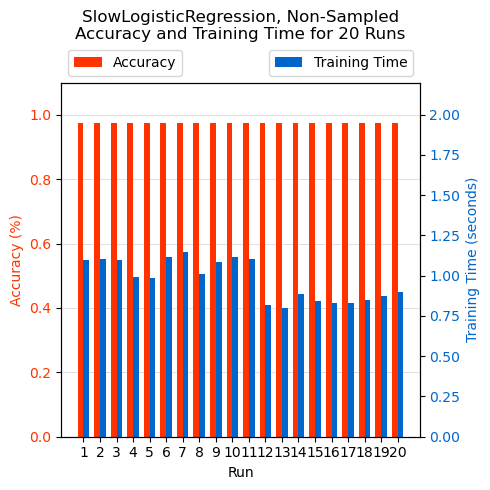

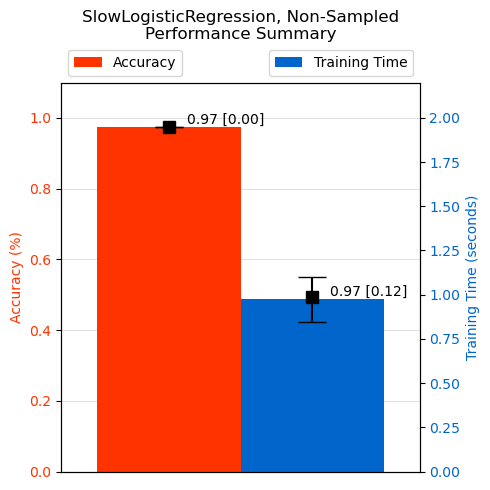

In [4]:
# Loading the breast cancer dataset.
data = load_breast_cancer()
X, y = data.data, data.target

# Running the experiment.
accuracies, training_times = run_experiment1(X, y, 20)

# Plotting the results.
plot_results(accuracies, training_times, 'SlowLogisticRegression, Non-Sampled', 'seconds')

## Experiment 2: `SlowLogisticRegression` Class, Sampled with `BasicLeverageScoresSampler`

Here, we analyze the performance of the `SlowLogisticRegression` class when 20% of the dataset is sampled with `BasicLeverageScoresSampler`. The code is run 20 times.

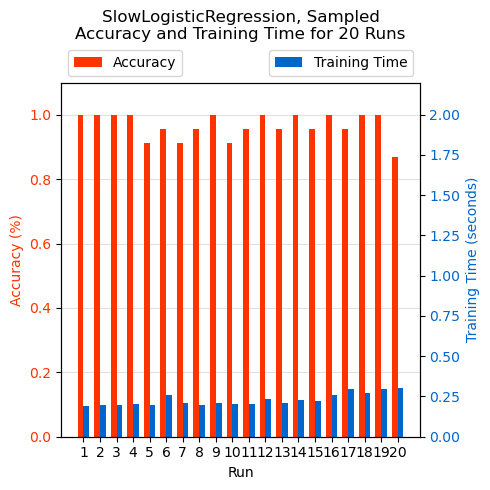

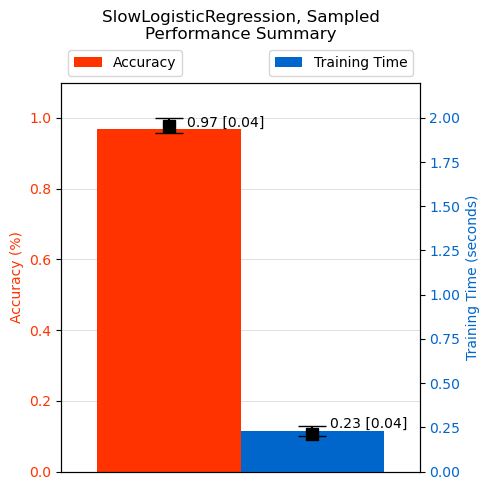

In [5]:
# Loading the breast cancer dataset.
data = load_breast_cancer()
X, y = data.data, data.target

# Running the experiment.
accuracies, training_times = run_experiment2(X, y, 20)

# Plotting the results.
plot_results(accuracies, training_times, 'SlowLogisticRegression, Sampled', 'seconds')

## Experiment 3: SciKit-Learn's `LogisticRegression` Class, Non-Sampled

Here, we analyze the performance of SciKit-Learn's `LogisticRegression` class without sampling. The code is run 20 times.

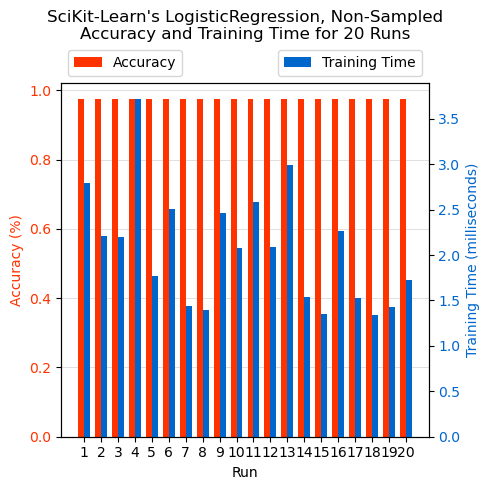

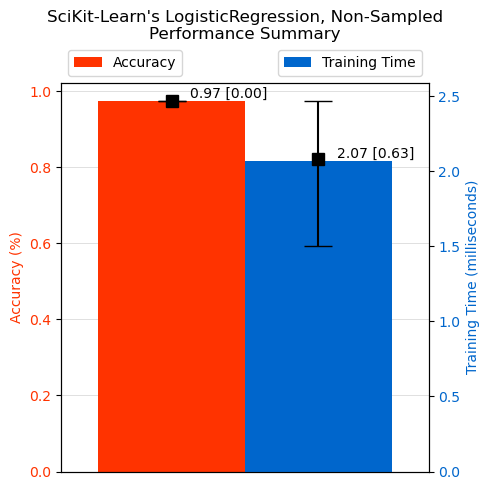

In [9]:
data = load_breast_cancer()
X = data.data
y = data.target

accuracies, training_times = run_experiment3(X, y, 20)
plot_results(accuracies, training_times, "SciKit-Learn's LogisticRegression, Non-Sampled", 'milliseconds', True)

## Experiment 4: SciKit-Learn's `LogisticRegression` Class, Sampled with `BasicOptimizedSampler`

Here, we analyze the performance of SciKitLearn's `SlowLogisticRegression` class with 20% of the dataset sampled with `BasicOptimizedSampler`. The code is run 20 times.

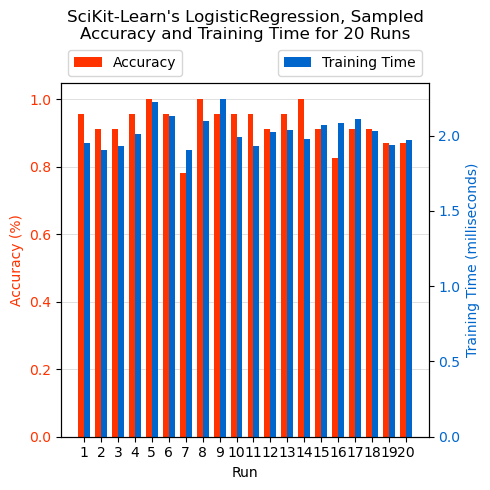

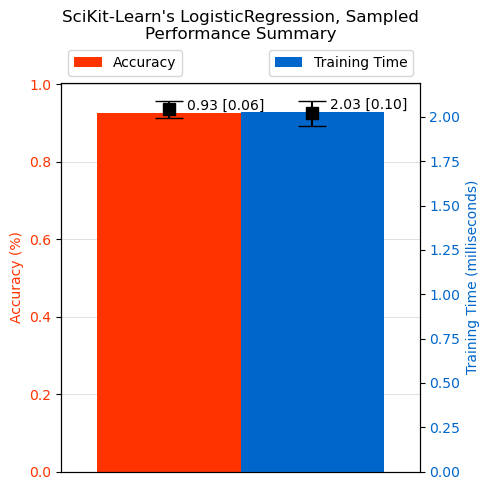

In [28]:
data = load_breast_cancer()
X = data.data
y = data.target

accuracies, training_times = run_experiment4(X, y, 20)
plot_results(accuracies, training_times, "SciKit-Learn's LogisticRegression, Sampled", 'milliseconds', True)

## Experiment 5: Increasing Number of Runs

Here, we increase the number of times each experiment is run to 1000, so as to increase statistical relevance of the observations.

In [1]:
accuracies1, training_times1 = run_experiment1(X, y, 1000)
accuracies2, training_times2 = run_experiment2(X, y, 1000)
accuracies3, training_times3 = run_experiment3(X, y, 1000)
accuracies4, training_times4 = run_experiment4(X, y, 1000)

NameError: name 'run_experiment1' is not defined